In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import signal

In [2]:
data_files = glob.glob("*.log")
print(len(data_files), data_files)

22 ['matt1-stair-60r.log', 'matt2-2r.log', 'matt2-standr.log', 'paul-standl.log', 'nick2-25l.log', 'abby2-2r.log', 'abby1-sitr.log', 'matt2-21l.log', 'paul-sitr.log', 'matt2-sitl.log', 'abby1-standl.log', 'abby1-stair-48r.log', 'paul-sitl.log', 'matt2-sitr.log', 'matt1-stair-66l.log', 'abby1-stair-72l.log', 'abby1-standr.log', 'abby2-22l.log', 'matt2-standl.log', 'paul-standr.log', 'nick2-25r.log', 'abby1-sitl.log']


In [304]:
WINDOW_SIZE = 110
WINDOW_STEP = 20

master = {}
phrase = "Acc X"
phrase2 = "Time taken by the task: 25 milliseconds"
phrase3 = "Time taken by the task: 24 milliseconds"
cols = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z']

sample_rate = 1/0.025 # Hz
num_channels = 9
ten_minutes =round(10*60*num_channels*sample_rate) #mins*seconds/min*num_channels*samples/second+ 1(python index start 0)
i = 0

data_x = np.zeros((1,110,9))
data_y = np.zeros((1,110))
train_X = []
train_Y = []
test_X = []
test_Y = []

for file in data_files:
    print(file)
    
    data = []
    with open(file) as f:
        f = f.readlines()

    for line in f[1:]:
        # Want to start beginning with x-acceleration measurements so data is alligned properly
        if line[:-1] == phrase:
            start = True
        if phrase not in line and phrase2 not in line and phrase3 not in line and start:
            data.append(float(line[:-1]))
    
    data = data[:ten_minutes]
    data = np.array(data)
    data = data.reshape((-1,9))
    print(data.shape)

    # Split into non-overlapping windows
    # Don't use the last bit of data that doesn't fill a whole window
    n_windows = data.shape[0] // WINDOW_SIZE
    end = WINDOW_SIZE * n_windows
    data = data[:end,:]

    # Split into overlapping windows
    data = np.lib.stride_tricks.sliding_window_view(data, WINDOW_SIZE, axis=0)[::WINDOW_STEP]
    data = data.transpose(0,2,1)
    print(data.shape)
    data_x = np.vstack((data_x, data))
    
    # upstairs
    if i==0 or i==11 or i==14 or i==15:
        data_y = np.vstack((data_y, 3*np.ones((data.shape[0], data.shape[1]))))
    # walking
    if i==1 or i==4 or i==5 or i==7 or i==17 or i==20:
        data_y = np.vstack((data_y, 2*np.ones((data.shape[0], data.shape[1]))))
    # standing
    if i==2 or i==3 or i==10 or i==16 or i==18 or i==19:
        data_y = np.vstack((data_y, np.ones((data.shape[0], data.shape[1]))))
    # sitting    
    if i==6 or i==8 or i==9 or i==12 or i==13 or i==21:
        data_y = np.vstack((data_y, np.zeros((data.shape[0], data.shape[1]))))
        
    i += 1
    
data_x = data_x[1:,:,:]
data_y = data_y[1:,:]
print(data_x.shape, data_y.shape)

np.random.seed(0)
indices = np.random.permutation(data_x.shape[0])
training_idx, test_idx = indices[:20818], indices[20818:]

train_X.append(data_x[training_idx])
train_Y.append(data_y[training_idx])
test_X.append(data_x[test_idx])
test_Y.append(data_y[test_idx])
train_X = np.concatenate(train_X, axis=0)
train_Y = np.concatenate(train_Y, axis=0)
train_Y = train_Y.reshape(-1,110)
test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)
test_Y = test_Y.reshape(-1,110)


matt1-stair-60r.log
(24000, 9)
(1194, 110, 9)
matt2-2r.log
(18235, 9)
(903, 110, 9)
matt2-standr.log
(24000, 9)
(1194, 110, 9)
paul-standl.log
(24000, 9)
(1194, 110, 9)
nick2-25l.log
(24000, 9)
(1194, 110, 9)
abby2-2r.log
(24000, 9)
(1194, 110, 9)
abby1-sitr.log
(24000, 9)
(1194, 110, 9)
matt2-21l.log
(24000, 9)
(1194, 110, 9)
paul-sitr.log
(24000, 9)
(1194, 110, 9)
matt2-sitl.log
(24000, 9)
(1194, 110, 9)
abby1-standl.log
(24000, 9)
(1194, 110, 9)
abby1-stair-48r.log
(24000, 9)
(1194, 110, 9)
paul-sitl.log
(24000, 9)
(1194, 110, 9)
matt2-sitr.log
(24000, 9)
(1194, 110, 9)
matt1-stair-66l.log
(24000, 9)
(1194, 110, 9)
abby1-stair-72l.log
(24000, 9)
(1194, 110, 9)
abby1-standr.log
(24000, 9)
(1194, 110, 9)
abby2-22l.log
(24000, 9)
(1194, 110, 9)
matt2-standl.log
(24000, 9)
(1194, 110, 9)
paul-standr.log
(24000, 9)
(1194, 110, 9)
nick2-25r.log
(24000, 9)
(1194, 110, 9)
abby1-sitl.log
(24000, 9)
(1194, 110, 9)
(25977, 110, 9) (25977, 110)


In [305]:
sample_x = train_X[0,:,0]
x_stretch = signal.resample(sample_x, int(len(sample_x) * 1.1))
x_squeeze = signal.resample(sample_x, int(len(sample_x) * 0.9))
x_shrink = sample_x * 0.8
x_scaled = sample_x * 1.2

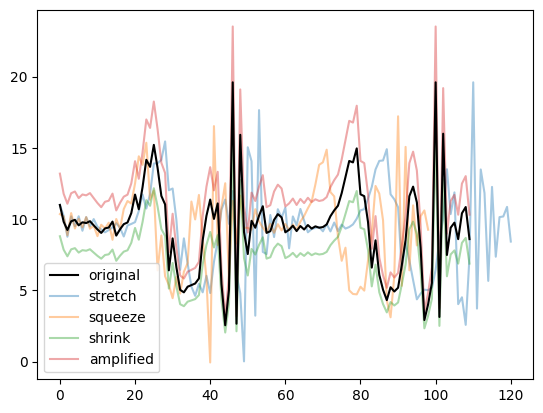

In [306]:
plt.plot(sample_x, label="original", zorder=4, c='k')
plt.plot(x_stretch, label="stretch", alpha=0.4)
plt.plot(x_squeeze, label="squeeze", alpha=0.4)
plt.plot(x_shrink, label="shrink", alpha=0.4)
plt.plot(x_scaled, label="amplified", alpha=0.4)
plt.legend()
plt.show()

In [323]:
class IMUDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        return inputs, labels


class IMUDataAugment:
    """
    Collate function to apply random time stretch/squeeze and signal shrink/scale
    Apply stretch/squeeze to the time dimension by resampling and truncating to out_samples
        The lower bound of stretch must satisfy (lb * len(input)) > out_samples
    """
    def __init__(self, out_samples=80, p=0.5, stretch=(0.8, 1.2), scale=(0.8, 1.2)):
        """
        Parameters:
        -----------
        p: float between [0, 1], probability of applying each the stretch and scale transform independently
        strech: tuple of float, upper and lower bound on time stretch factor
        scale: tuple of float, upper and lower bound on signal scale factor
        """
        self.p = p
        self.stretch = stretch
        self.scale = scale
        self.out_samples = out_samples
    

    def _random_crop(self, inputs, labels):
        """Apply a random crop of the signal of length self.out_samples to both inputs and labels"""
        n, d = inputs.shape
        max_offset = n - self.out_samples
        offset = np.random.choice(max_offset)
        inds = slice(offset, offset + self.out_samples)
        return inputs[inds, :], labels[inds]

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (inputs, labels) of length batch_size
            inputs: np.ndarray, dimensions (n_samples, n_channels), signal data
            labels: np.ndarray, dimensions (n_samples,), binary label vector for the signal data

        Returns:
        --------
        (inputs, labels): augmented signal data, reduced labels
        """
        x = []
        y = []
        for (inputs, labels) in data:
            
            n, d = inputs.shape
            assert (self.stretch[0] * n) >= self.out_samples, f"input size {n} must be greater than {int(self.out_samples / self.stretch[0])} to apply augmentation"

            # Randomly apply time stretch
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.stretch
                stretch = np.random.uniform(lb, ub)
                inputs = signal.resample(inputs, int(n * stretch), axis=0)  # Resample the time (n_samples) axis
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.scale
                scale = np.random.uniform(lb, ub)
                inputs = scale * inputs  # Scale all channels equally
            
            # Apply random crop to self.out_size on both inputs and labels
            inputs, labels = self._random_crop(inputs, labels)

            x.append(inputs)
            y.append(labels.mean())
            
        collated_inputs = torch.tensor(x, dtype=torch.float32)
        collated_labels = torch.tensor(y, dtype=torch.float32)
        

        return collated_inputs, collated_labels

In [369]:
train_dataset = IMUDataset(train_X, train_Y)
test_dataset = IMUDataset(test_X, test_Y)

augment_fn = IMUDataAugment(out_samples=80)
test_augment = IMUDataAugment(out_samples=80, p=0)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=augment_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_augment)
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [370]:
train_X.shape

(20818, 110, 9)

In [371]:
train_Y.shape

(20818, 110)

In [372]:
import torch.nn.functional as f

def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets = torch.tensor(targets.flatten(), dtype=torch.int64)
        labels = targets
        targets = f.one_hot(targets,4)
        outputs = model(inputs.double())
        loss = criterion(outputs.double(), targets.double())
        loss.backward()
        optimizer.step()

        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.argmax(outputs,dim=1)
        correct += torch.sum(preds == labels).detach().cpu()

        if i % logging_steps == 0:
            print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

In [373]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import matplotlib.pyplot as plt

def evaluate(model, dataloader, criterion, epoch, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets = torch.tensor(targets.flatten(), dtype=torch.int64)
            labels = targets
            targets = f.one_hot(targets,4)
            outputs = model(inputs.double())
            loss = criterion(outputs.double(), targets.double())

            total_loss += loss
            preds = torch.argmax(outputs,dim=1)
            
            
            correct += torch.sum(preds == labels).detach().cpu()
            all_preds.append(preds.flatten().numpy())
            all_labels.append(labels.flatten().numpy())
            
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0) 
        cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
        disp.plot()
        plt.show()
            
        
        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Epoch {epoch} done. Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)

In [374]:
# Classes
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bi):
        super(GRUModel, self).__init__()

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bi
        )

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)

    def forward(self, x):
        
        out, _ = self.gru(x)

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out.flatten(start_dim=-2))

        return torch.sigmoid(out)
    
    
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bi):
        super(LSTMModel, self).__init__()

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bi
        )

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)

    def forward(self, x):

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x)

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out.flatten(start_dim=-2))

        return torch.sigmoid(out)

0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
6it [00:00, 28.48it/s]

Epoch: 0 (0/326) Training loss: 1.3914049281441252


25it [00:00, 40.82it/s]

Epoch: 0 (20/326) Training loss: 1.0831424456288186


45it [00:01, 43.19it/s]

Epoch: 0 (40/326) Training loss: 1.0224289863776161


70it [00:01, 44.49it/s]

Epoch: 0 (60/326) Training loss: 0.9746603095688742


90it [00:02, 44.91it/s]

Epoch: 0 (80/326) Training loss: 0.9284625903204133


110it [00:02, 45.35it/s]

Epoch: 0 (100/326) Training loss: 0.9372541252011486


130it [00:03, 45.42it/s]

Epoch: 0 (120/326) Training loss: 0.8740662071419715


150it [00:03, 45.04it/s]

Epoch: 0 (140/326) Training loss: 0.9020058821829762


170it [00:03, 45.55it/s]

Epoch: 0 (160/326) Training loss: 0.8825612645823062


190it [00:04, 46.14it/s]

Epoch: 0 (180/326) Training loss: 0.8670891296341967


210it [00:04, 46.10it/s]

Epoch: 0 (200/326) Training loss: 0.8511447546730952


225it [00:05, 43.79it/s]

Epoch: 0 (220/326) Training loss: 0.8496469051370964


250it [00:05, 45.80it/s]

Epoch: 0 (240/326) Training loss: 0.8142696306018383


270it [00:06, 46.78it/s]

Epoch: 0 (260/326) Training loss: 0.7999842493290433


290it [00:06, 46.94it/s]

Epoch: 0 (280/326) Training loss: 0.7868233817846756


310it [00:06, 46.96it/s]

Epoch: 0 (300/326) Training loss: 0.7980173058695417


326it [00:07, 44.77it/s]


Epoch: 0 (320/326) Training loss: 0.8030232211955176
Epoch 0 done. Training loss: 0.8957089140409294 Training accuracy: 0.7666794657707214


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 89.79it/s]


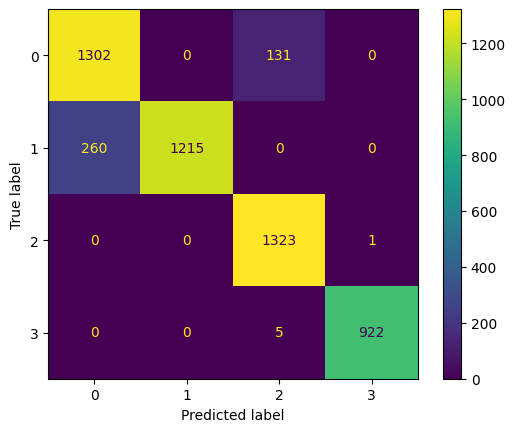

Epoch 0 done. Eval loss: 0.7899745322725256 Eval accuracy: 0.9185956716537476


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 38.99it/s]

Epoch: 1 (0/326) Training loss: 0.787663474706453


28it [00:00, 44.21it/s]

Epoch: 1 (20/326) Training loss: 0.7792759291197178


48it [00:01, 40.88it/s]

Epoch: 1 (40/326) Training loss: 0.8042879613001369


68it [00:01, 42.10it/s]

Epoch: 1 (60/326) Training loss: 0.7690433334834701


88it [00:02, 43.19it/s]

Epoch: 1 (80/326) Training loss: 0.7792387348655158


108it [00:02, 43.61it/s]

Epoch: 1 (100/326) Training loss: 0.7766710181011156


128it [00:02, 43.65it/s]

Epoch: 1 (120/326) Training loss: 0.7564322882968018


148it [00:03, 43.18it/s]

Epoch: 1 (140/326) Training loss: 0.770032497006012


168it [00:03, 44.93it/s]

Epoch: 1 (160/326) Training loss: 0.7747147530618415


188it [00:04, 45.35it/s]

Epoch: 1 (180/326) Training loss: 0.7568552295587162


208it [00:04, 45.96it/s]

Epoch: 1 (200/326) Training loss: 0.7611290086182043


228it [00:05, 46.36it/s]

Epoch: 1 (220/326) Training loss: 0.7505181956832827


248it [00:05, 46.41it/s]

Epoch: 1 (240/326) Training loss: 0.762523086309584


268it [00:06, 46.77it/s]

Epoch: 1 (260/326) Training loss: 0.7519073474561903


288it [00:06, 46.85it/s]

Epoch: 1 (280/326) Training loss: 0.7598625608167411


308it [00:06, 47.08it/s]

Epoch: 1 (300/326) Training loss: 0.7616964390570168


326it [00:07, 44.77it/s]


Epoch: 1 (320/326) Training loss: 0.7541930031064372
Epoch 1 done. Training loss: 0.7679222940446803 Training accuracy: 0.9513036608695984


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 90.14it/s]


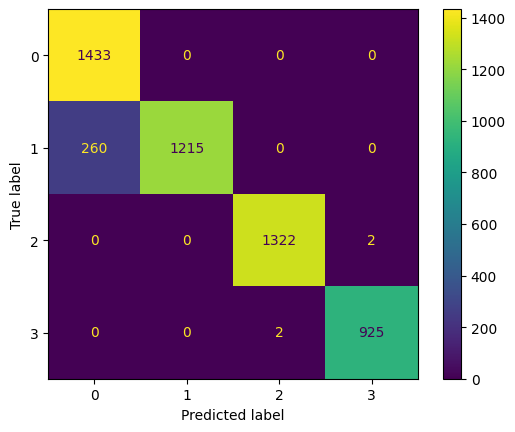

Epoch 1 done. Eval loss: 0.7594425476963396 Eval accuracy: 0.944251537322998


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
5it [00:00, 41.20it/s]

Epoch: 2 (0/326) Training loss: 0.7613603200382058


30it [00:00, 46.19it/s]

Epoch: 2 (20/326) Training loss: 0.7542636893199448


50it [00:01, 46.06it/s]

Epoch: 2 (40/326) Training loss: 0.7532188056911626


65it [00:01, 41.32it/s]

Epoch: 2 (60/326) Training loss: 0.7519759694408698


90it [00:02, 45.51it/s]

Epoch: 2 (80/326) Training loss: 0.7653050315338412


110it [00:02, 46.69it/s]

Epoch: 2 (100/326) Training loss: 0.7620481795331077


130it [00:02, 46.59it/s]

Epoch: 2 (120/326) Training loss: 0.7649412436330635


145it [00:03, 46.57it/s]

Epoch: 2 (140/326) Training loss: 0.764800106757391


170it [00:03, 44.22it/s]

Epoch: 2 (160/326) Training loss: 0.760734469392329


190it [00:04, 45.86it/s]

Epoch: 2 (180/326) Training loss: 0.7608682789075842


205it [00:04, 44.91it/s]

Epoch: 2 (200/326) Training loss: 0.764793628693449


230it [00:05, 46.13it/s]

Epoch: 2 (220/326) Training loss: 0.7565455265228443


250it [00:05, 46.48it/s]

Epoch: 2 (240/326) Training loss: 0.758800669215672


270it [00:05, 46.49it/s]

Epoch: 2 (260/326) Training loss: 0.748406626965263


290it [00:06, 46.84it/s]

Epoch: 2 (280/326) Training loss: 0.7529838936059587


310it [00:06, 46.58it/s]

Epoch: 2 (300/326) Training loss: 0.7609851484191407


326it [00:07, 45.45it/s]


Epoch: 2 (320/326) Training loss: 0.7648651504523909
Epoch 2 done. Training loss: 0.7570304238860183 Training accuracy: 0.9535084366798401


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 88.69it/s]


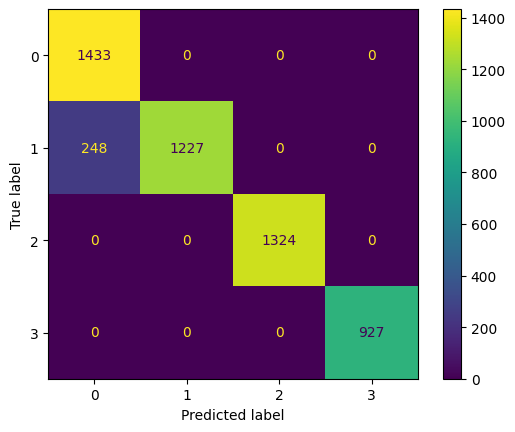

Epoch 2 done. Eval loss: 0.7578581825960062 Eval accuracy: 0.9473379850387573


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 37.95it/s]

Epoch: 3 (0/326) Training loss: 0.7484347953387805


29it [00:00, 43.96it/s]

Epoch: 3 (20/326) Training loss: 0.7569034712659712


49it [00:01, 45.03it/s]

Epoch: 3 (40/326) Training loss: 0.7488552338000085


69it [00:01, 44.76it/s]

Epoch: 3 (60/326) Training loss: 0.7566375998736622


89it [00:02, 45.38it/s]

Epoch: 3 (80/326) Training loss: 0.7607401081509853


109it [00:02, 45.93it/s]

Epoch: 3 (100/326) Training loss: 0.7527334243169858


129it [00:02, 46.07it/s]

Epoch: 3 (120/326) Training loss: 0.7526542156552763


149it [00:03, 45.36it/s]

Epoch: 3 (140/326) Training loss: 0.7441500367500017


169it [00:03, 46.03it/s]

Epoch: 3 (160/326) Training loss: 0.7444605744758233


189it [00:04, 45.78it/s]

Epoch: 3 (180/326) Training loss: 0.7647210026023826


209it [00:04, 45.78it/s]

Epoch: 3 (200/326) Training loss: 0.7617008233892013


229it [00:05, 45.42it/s]

Epoch: 3 (220/326) Training loss: 0.7645655225609475


249it [00:05, 45.67it/s]

Epoch: 3 (240/326) Training loss: 0.7525792053302992


269it [00:05, 45.60it/s]

Epoch: 3 (260/326) Training loss: 0.7570081734010181


289it [00:06, 45.95it/s]

Epoch: 3 (280/326) Training loss: 0.748078709664352


309it [00:06, 46.62it/s]

Epoch: 3 (300/326) Training loss: 0.764892174133067


326it [00:07, 45.42it/s]


Epoch: 3 (320/326) Training loss: 0.7727931158963974
Epoch 3 done. Training loss: 0.7562193474770622 Training accuracy: 0.95820552110672


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 89.62it/s]


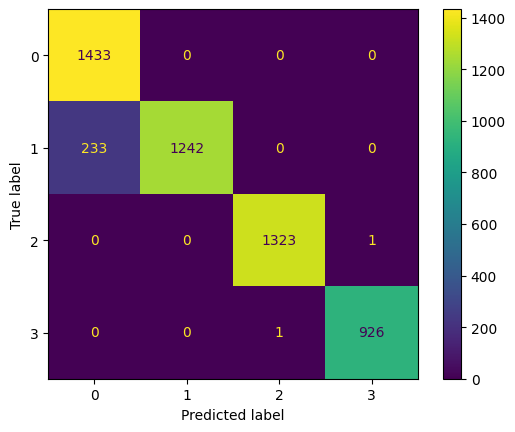

Epoch 3 done. Eval loss: 0.7576299694087432 Eval accuracy: 0.9498456716537476


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 39.47it/s]

Epoch: 4 (0/326) Training loss: 0.7649324234470517


29it [00:00, 45.19it/s]

Epoch: 4 (20/326) Training loss: 0.7564826783439121


49it [00:01, 46.87it/s]

Epoch: 4 (40/326) Training loss: 0.7481710102622174


69it [00:01, 46.88it/s]

Epoch: 4 (60/326) Training loss: 0.7563498433516903


89it [00:01, 47.42it/s]

Epoch: 4 (80/326) Training loss: 0.7643724951813657


109it [00:02, 47.34it/s]

Epoch: 4 (100/326) Training loss: 0.7480149904884955


129it [00:02, 47.29it/s]

Epoch: 4 (120/326) Training loss: 0.7564918571048556


149it [00:03, 46.71it/s]

Epoch: 4 (140/326) Training loss: 0.7565907604218755


169it [00:03, 47.14it/s]

Epoch: 4 (160/326) Training loss: 0.7611932545405806


189it [00:04, 46.75it/s]

Epoch: 4 (180/326) Training loss: 0.7604590656777191


209it [00:04, 45.90it/s]

Epoch: 4 (200/326) Training loss: 0.7480803826542108


229it [00:04, 46.41it/s]

Epoch: 4 (220/326) Training loss: 0.7442462768448296


249it [00:05, 46.50it/s]

Epoch: 4 (240/326) Training loss: 0.7603310901122926


269it [00:05, 46.49it/s]

Epoch: 4 (260/326) Training loss: 0.7438445791699476


289it [00:06, 46.85it/s]

Epoch: 4 (280/326) Training loss: 0.7562990822500364


309it [00:06, 46.88it/s]

Epoch: 4 (300/326) Training loss: 0.756391808143544


326it [00:07, 46.54it/s]


Epoch: 4 (320/326) Training loss: 0.744076351176049
Epoch 4 done. Training loss: 0.7559982421692956 Training accuracy: 0.9660659432411194


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 89.50it/s]


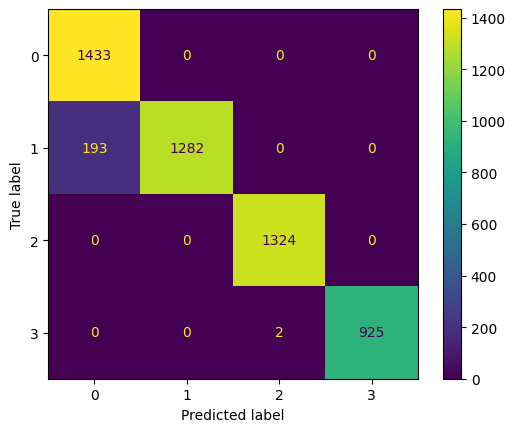

Epoch 4 done. Eval loss: 0.7574688885452553 Eval accuracy: 0.957561731338501


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 35.40it/s]

Epoch: 5 (0/326) Training loss: 0.7480143753180923


29it [00:00, 44.93it/s]

Epoch: 5 (20/326) Training loss: 0.7521780037838358


49it [00:01, 45.64it/s]

Epoch: 5 (40/326) Training loss: 0.7685800326120722


69it [00:01, 45.30it/s]

Epoch: 5 (60/326) Training loss: 0.7480448275311811


89it [00:01, 46.40it/s]

Epoch: 5 (80/326) Training loss: 0.7480552115200729


109it [00:02, 46.46it/s]

Epoch: 5 (100/326) Training loss: 0.7510600055086478


129it [00:02, 46.50it/s]

Epoch: 5 (120/326) Training loss: 0.7446915585928795


149it [00:03, 45.76it/s]

Epoch: 5 (140/326) Training loss: 0.7446562645677045


169it [00:03, 46.23it/s]

Epoch: 5 (160/326) Training loss: 0.7441678215861418


189it [00:04, 46.39it/s]

Epoch: 5 (180/326) Training loss: 0.7442315031542897


209it [00:04, 46.57it/s]

Epoch: 5 (200/326) Training loss: 0.7439058802437819


229it [00:05, 46.64it/s]

Epoch: 5 (220/326) Training loss: 0.7439322325179023


249it [00:05, 46.71it/s]

Epoch: 5 (240/326) Training loss: 0.7439354885006759


269it [00:05, 46.68it/s]

Epoch: 5 (260/326) Training loss: 0.7438666958737492


289it [00:06, 44.97it/s]

Epoch: 5 (280/326) Training loss: 0.7440421651448644


309it [00:06, 46.50it/s]

Epoch: 5 (300/326) Training loss: 0.7445356447246556


326it [00:07, 45.94it/s]


Epoch: 5 (320/326) Training loss: 0.7438229615487979
Epoch 5 done. Training loss: 0.7482555651843301 Training accuracy: 0.993194043636322


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 85.49it/s]


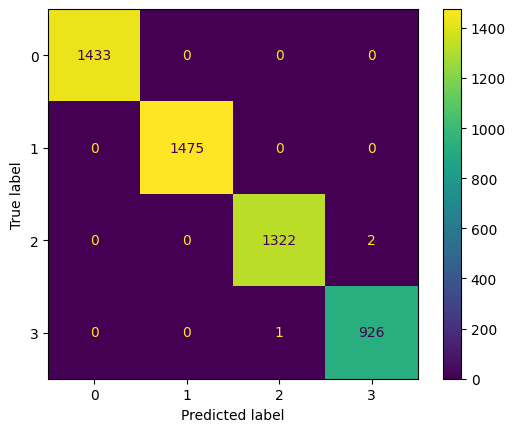

Epoch 5 done. Eval loss: 0.7443988569447169 Eval accuracy: 0.9945987462997437


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 37.10it/s]

Epoch: 6 (0/326) Training loss: 0.743872126386802


29it [00:00, 44.03it/s]

Epoch: 6 (20/326) Training loss: 0.7440762188831357


49it [00:01, 45.84it/s]

Epoch: 6 (40/326) Training loss: 0.7440250710778833


69it [00:01, 45.79it/s]

Epoch: 6 (60/326) Training loss: 0.7442155301843151


89it [00:01, 46.01it/s]

Epoch: 6 (80/326) Training loss: 0.7439433161337042


109it [00:02, 46.86it/s]

Epoch: 6 (100/326) Training loss: 0.7438175276746877


129it [00:02, 46.27it/s]

Epoch: 6 (120/326) Training loss: 0.7438277759615046


149it [00:03, 46.69it/s]

Epoch: 6 (140/326) Training loss: 0.7438240358009226


169it [00:03, 46.55it/s]

Epoch: 6 (160/326) Training loss: 0.7438219366448379


189it [00:04, 46.25it/s]

Epoch: 6 (180/326) Training loss: 0.7460804308036366


209it [00:04, 46.91it/s]

Epoch: 6 (200/326) Training loss: 0.743905579759863


229it [00:04, 46.67it/s]

Epoch: 6 (220/326) Training loss: 0.7438077325303678


249it [00:05, 47.00it/s]

Epoch: 6 (240/326) Training loss: 0.7438443925890126


269it [00:05, 47.09it/s]

Epoch: 6 (260/326) Training loss: 0.7437870842605531


289it [00:06, 46.69it/s]

Epoch: 6 (280/326) Training loss: 0.7438526075448586


309it [00:06, 46.80it/s]

Epoch: 6 (300/326) Training loss: 0.7437827478102748


326it [00:07, 46.25it/s]


Epoch: 6 (320/326) Training loss: 0.7438431439561968
Epoch 6 done. Training loss: 0.7440990990185083 Training accuracy: 0.9976993799209595


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 89.03it/s]


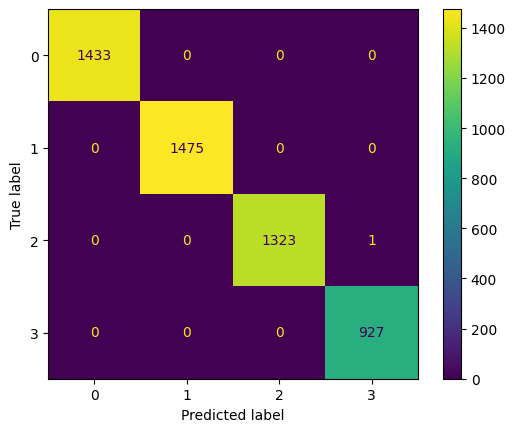

Epoch 6 done. Eval loss: 0.7440157005491604 Eval accuracy: 0.9949845671653748


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 37.43it/s]

Epoch: 7 (0/326) Training loss: 0.7443818959588959


29it [00:00, 45.19it/s]

Epoch: 7 (20/326) Training loss: 0.7440424883703414


49it [00:01, 46.21it/s]

Epoch: 7 (40/326) Training loss: 0.7437666666933198


69it [00:01, 46.22it/s]

Epoch: 7 (60/326) Training loss: 0.7439962973810661


89it [00:01, 46.23it/s]

Epoch: 7 (80/326) Training loss: 0.7437795719139766


109it [00:02, 44.61it/s]

Epoch: 7 (100/326) Training loss: 0.7437748462694622


129it [00:02, 45.79it/s]

Epoch: 7 (120/326) Training loss: 0.7437623405207063


149it [00:03, 46.01it/s]

Epoch: 7 (140/326) Training loss: 0.7437718354595756


169it [00:03, 46.91it/s]

Epoch: 7 (160/326) Training loss: 0.7437836824157968


189it [00:04, 46.96it/s]

Epoch: 7 (180/326) Training loss: 0.7437342615429787


209it [00:04, 47.10it/s]

Epoch: 7 (200/326) Training loss: 0.7439183649716258


229it [00:04, 46.82it/s]

Epoch: 7 (220/326) Training loss: 0.7437830793991907


249it [00:05, 46.78it/s]

Epoch: 7 (240/326) Training loss: 0.7437298359105017


269it [00:05, 47.12it/s]

Epoch: 7 (260/326) Training loss: 0.7438812760879193


289it [00:06, 46.74it/s]

Epoch: 7 (280/326) Training loss: 0.7437402184402742


309it [00:06, 46.98it/s]

Epoch: 7 (300/326) Training loss: 0.7437266988815034


326it [00:07, 46.24it/s]


Epoch: 7 (320/326) Training loss: 0.7438688377543222
Epoch 7 done. Training loss: 0.7438507331875797 Training accuracy: 0.9977952241897583


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 89.50it/s]


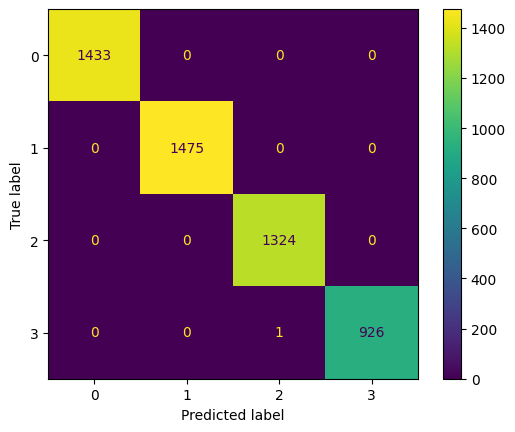

Epoch 7 done. Eval loss: 0.7440400209443805 Eval accuracy: 0.9949845671653748


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
5it [00:00, 41.43it/s]

Epoch: 8 (0/326) Training loss: 0.7437668777224626


30it [00:00, 45.62it/s]

Epoch: 8 (20/326) Training loss: 0.7438138164854026


50it [00:01, 46.01it/s]

Epoch: 8 (40/326) Training loss: 0.7450417748540323


70it [00:01, 45.51it/s]

Epoch: 8 (60/326) Training loss: 0.7437367679053533


85it [00:01, 40.14it/s]

Epoch: 8 (80/326) Training loss: 0.7437806458215915


110it [00:02, 44.76it/s]

Epoch: 8 (100/326) Training loss: 0.7437433296128869


130it [00:02, 45.51it/s]

Epoch: 8 (120/326) Training loss: 0.7437397056305841


150it [00:03, 46.18it/s]

Epoch: 8 (140/326) Training loss: 0.7437184823336631


170it [00:03, 46.89it/s]

Epoch: 8 (160/326) Training loss: 0.7441217958601964


190it [00:04, 46.94it/s]

Epoch: 8 (180/326) Training loss: 0.7442283426888785


210it [00:04, 46.86it/s]

Epoch: 8 (200/326) Training loss: 0.744031063200139


230it [00:05, 46.78it/s]

Epoch: 8 (220/326) Training loss: 0.743876771659747


250it [00:05, 46.89it/s]

Epoch: 8 (240/326) Training loss: 0.7438197219386773


270it [00:05, 46.73it/s]

Epoch: 8 (260/326) Training loss: 0.7438374009110482


290it [00:06, 46.07it/s]

Epoch: 8 (280/326) Training loss: 0.7437888290666371


310it [00:06, 46.43it/s]

Epoch: 8 (300/326) Training loss: 0.7439002647492332


326it [00:07, 45.84it/s]


Epoch: 8 (320/326) Training loss: 0.7438686551790095
Epoch 8 done. Training loss: 0.7440255996065913 Training accuracy: 0.9976993799209595


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 89.25it/s]


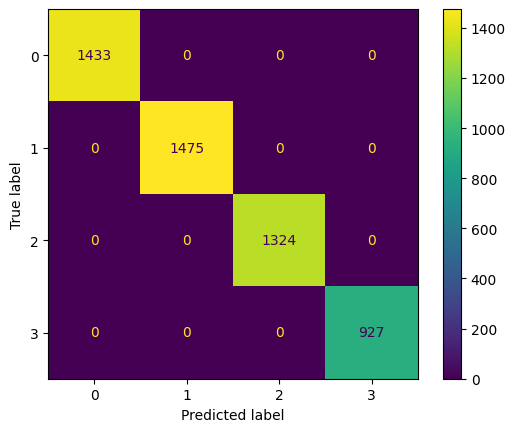

Epoch 8 done. Eval loss: 0.7438245257312807 Eval accuracy: 0.9951774477958679


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 35.58it/s]

Epoch: 9 (0/326) Training loss: 0.7437279055022927


29it [00:00, 44.80it/s]

Epoch: 9 (20/326) Training loss: 0.7437748104687907


49it [00:01, 45.05it/s]

Epoch: 9 (40/326) Training loss: 0.7439321363690891


69it [00:01, 46.35it/s]

Epoch: 9 (60/326) Training loss: 0.7437671707780693


89it [00:01, 46.15it/s]

Epoch: 9 (80/326) Training loss: 0.7438683789096541


109it [00:02, 45.42it/s]

Epoch: 9 (100/326) Training loss: 0.7437346267899881


129it [00:02, 46.42it/s]

Epoch: 9 (120/326) Training loss: 0.743743000726383


149it [00:03, 46.32it/s]

Epoch: 9 (140/326) Training loss: 0.7437690125870233


169it [00:03, 45.02it/s]

Epoch: 9 (160/326) Training loss: 0.7437795643313693


189it [00:04, 44.18it/s]

Epoch: 9 (180/326) Training loss: 0.7437917092134464


209it [00:04, 45.53it/s]

Epoch: 9 (200/326) Training loss: 0.7443798189101161


229it [00:05, 44.20it/s]

Epoch: 9 (220/326) Training loss: 0.7438936486718164


249it [00:05, 46.04it/s]

Epoch: 9 (240/326) Training loss: 0.7437494130221238


269it [00:05, 46.11it/s]

Epoch: 9 (260/326) Training loss: 0.7437194746814337


289it [00:06, 46.46it/s]

Epoch: 9 (280/326) Training loss: 0.7437749149067006


309it [00:06, 46.05it/s]

Epoch: 9 (300/326) Training loss: 0.7437253914607408


326it [00:07, 45.36it/s]


Epoch: 9 (320/326) Training loss: 0.7437469048765404
Epoch 9 done. Training loss: 0.7438868598601306 Training accuracy: 0.9977952241897583


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 87.89it/s]


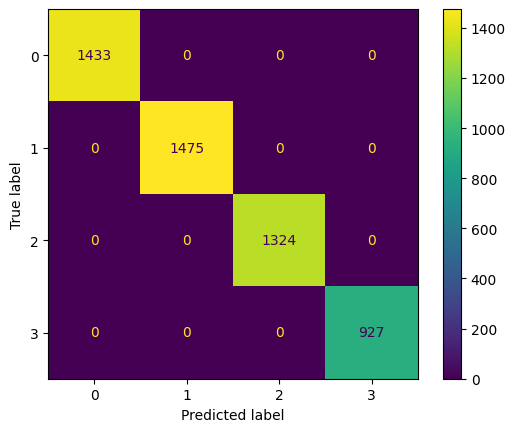

Epoch 9 done. Eval loss: 0.743790403680619 Eval accuracy: 0.9951774477958679


In [376]:
import torch.nn.functional as f
# LSTM 1
input_dim = 9
hidden_dim = 7 
layer_dim = 1 
output_dim = 4 
dropout_prob = 0
fc_dim = 1120
bi = True
rnn = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim,bi)
optimizer = torch.optim.Adam(rnn.parameters(),lr=1e-3,weight_decay=0)
rnn.double()

criterion = nn.CrossEntropyLoss()

EPOCHS = 10

loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(rnn, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(rnn, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)

0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
11it [00:00, 52.45it/s]

Epoch: 0 (0/326) Training loss: 1.4049075961832291


35it [00:00, 67.32it/s]

Epoch: 0 (20/326) Training loss: 1.0470293104980324


51it [00:00, 70.61it/s]

Epoch: 0 (40/326) Training loss: 0.9606590093163425


75it [00:01, 71.59it/s]

Epoch: 0 (60/326) Training loss: 0.9375780744113217


91it [00:01, 71.21it/s]

Epoch: 0 (80/326) Training loss: 0.9018144867416812


115it [00:01, 71.68it/s]

Epoch: 0 (100/326) Training loss: 0.8985411014842342


131it [00:01, 72.27it/s]

Epoch: 0 (120/326) Training loss: 0.8623948501505595


155it [00:02, 73.74it/s]

Epoch: 0 (140/326) Training loss: 0.8605024670766777


171it [00:02, 75.51it/s]

Epoch: 0 (160/326) Training loss: 0.8372674763928875


196it [00:02, 77.79it/s]

Epoch: 0 (180/326) Training loss: 0.8519021514854521


212it [00:02, 76.49it/s]

Epoch: 0 (200/326) Training loss: 0.8394486689291136


228it [00:03, 75.04it/s]

Epoch: 0 (220/326) Training loss: 0.8790472843518692


252it [00:03, 76.98it/s]

Epoch: 0 (240/326) Training loss: 0.8246319783134808


276it [00:03, 78.24it/s]

Epoch: 0 (260/326) Training loss: 0.8034673483626278


292it [00:03, 78.44it/s]

Epoch: 0 (280/326) Training loss: 0.785154231993335


317it [00:04, 79.45it/s]

Epoch: 0 (300/326) Training loss: 0.8185785200627587


326it [00:04, 74.08it/s]


Epoch: 0 (320/326) Training loss: 0.8173131467157791
Epoch 0 done. Training loss: 0.8766945556850078 Training accuracy: 0.8084739446640015


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 126.40it/s]


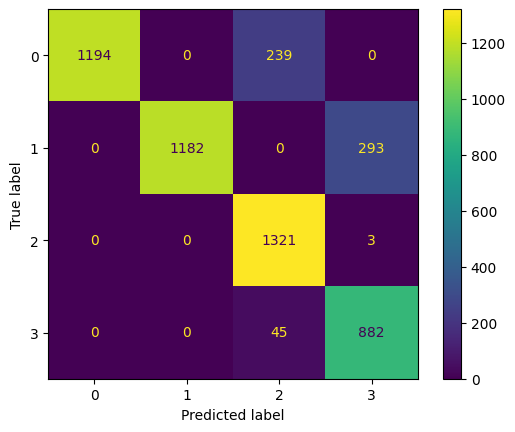

Epoch 0 done. Eval loss: 0.826608155145169 Eval accuracy: 0.8832947611808777


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 65.70it/s]

Epoch: 1 (0/326) Training loss: 0.8135272995704961


31it [00:00, 74.27it/s]

Epoch: 1 (20/326) Training loss: 0.8405586972965711


55it [00:00, 75.37it/s]

Epoch: 1 (40/326) Training loss: 0.7897380546775719


71it [00:00, 76.76it/s]

Epoch: 1 (60/326) Training loss: 0.768290946176923


96it [00:01, 76.70it/s]

Epoch: 1 (80/326) Training loss: 0.7947835241466736


112it [00:01, 76.40it/s]

Epoch: 1 (100/326) Training loss: 0.8267793532488883


136it [00:01, 76.34it/s]

Epoch: 1 (120/326) Training loss: 0.8197761602268478


152it [00:02, 77.69it/s]

Epoch: 1 (140/326) Training loss: 0.7947710725693126


176it [00:02, 78.41it/s]

Epoch: 1 (160/326) Training loss: 0.8237693411574813


192it [00:02, 76.74it/s]

Epoch: 1 (180/326) Training loss: 0.8767184592731243


216it [00:02, 77.06it/s]

Epoch: 1 (200/326) Training loss: 0.8037260103057923


232it [00:03, 78.03it/s]

Epoch: 1 (220/326) Training loss: 0.8125482499581033


256it [00:03, 77.60it/s]

Epoch: 1 (240/326) Training loss: 0.7766494045529838


272it [00:03, 75.56it/s]

Epoch: 1 (260/326) Training loss: 0.8424400500982778


297it [00:03, 78.85it/s]

Epoch: 1 (280/326) Training loss: 0.7844696638614501


313it [00:04, 78.91it/s]

Epoch: 1 (300/326) Training loss: 0.8031566539079187


326it [00:04, 77.02it/s]


Epoch: 1 (320/326) Training loss: 0.8250714585604869
Epoch 1 done. Training loss: 0.8150384143021571 Training accuracy: 0.8935007452964783


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 135.33it/s]


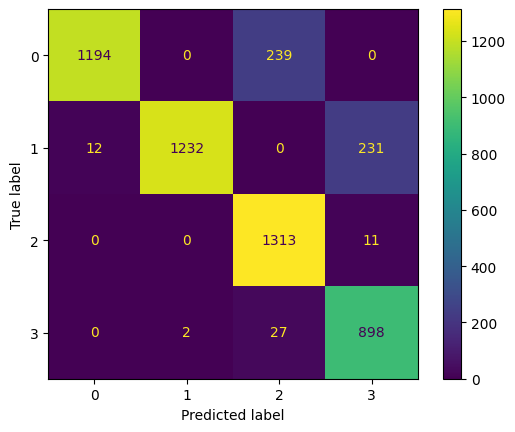

Epoch 1 done. Eval loss: 0.7984595692615957 Eval accuracy: 0.8944830298423767


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
8it [00:00, 73.30it/s]

Epoch: 2 (0/326) Training loss: 0.814501106585865


33it [00:00, 78.11it/s]

Epoch: 2 (20/326) Training loss: 0.8113366168129391


51it [00:00, 79.81it/s]

Epoch: 2 (40/326) Training loss: 0.7869330986389526


77it [00:00, 80.11it/s]

Epoch: 2 (60/326) Training loss: 0.798782524852417


94it [00:01, 79.50it/s]

Epoch: 2 (80/326) Training loss: 0.7804509191820947


110it [00:01, 74.62it/s]

Epoch: 2 (100/326) Training loss: 0.796707858815444


134it [00:01, 73.15it/s]

Epoch: 2 (120/326) Training loss: 0.766472540169726


151it [00:01, 76.34it/s]

Epoch: 2 (140/326) Training loss: 0.7839660407430584


168it [00:02, 77.06it/s]

Epoch: 2 (160/326) Training loss: 0.8181765186455201


193it [00:02, 76.70it/s]

Epoch: 2 (180/326) Training loss: 0.8195067234152646


209it [00:02, 76.59it/s]

Epoch: 2 (200/326) Training loss: 0.7905222141137983


233it [00:03, 75.54it/s]

Epoch: 2 (220/326) Training loss: 0.7564916555840502


249it [00:03, 75.14it/s]

Epoch: 2 (240/326) Training loss: 0.8130702902048941


273it [00:03, 76.39it/s]

Epoch: 2 (260/326) Training loss: 0.7528840097492897


289it [00:03, 72.18it/s]

Epoch: 2 (280/326) Training loss: 0.7845911283558273


312it [00:04, 69.34it/s]

Epoch: 2 (300/326) Training loss: 0.7980107059068412


326it [00:04, 75.46it/s]


Epoch: 2 (320/326) Training loss: 0.7980753978570312
Epoch 2 done. Training loss: 0.7951216479439945 Training accuracy: 0.8998754024505615


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 133.91it/s]


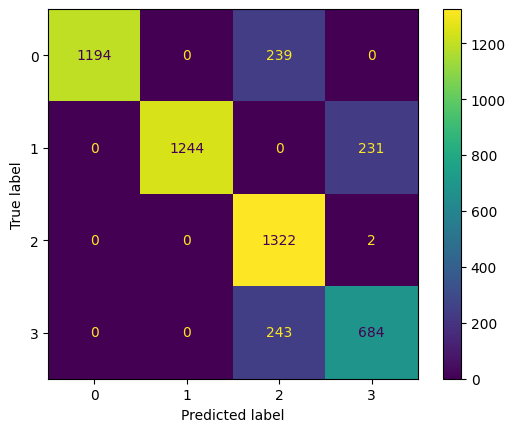

Epoch 2 done. Eval loss: 0.8355362629476348 Eval accuracy: 0.8572530746459961


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 67.25it/s]

Epoch: 3 (0/326) Training loss: 0.787919767929392


31it [00:00, 73.48it/s]

Epoch: 3 (20/326) Training loss: 0.7520163414355929


56it [00:00, 77.44it/s]

Epoch: 3 (40/326) Training loss: 0.7864738849834374


72it [00:00, 77.04it/s]

Epoch: 3 (60/326) Training loss: 0.7739596616381637


96it [00:01, 75.80it/s]

Epoch: 3 (80/326) Training loss: 0.7718994241546672


112it [00:01, 76.37it/s]

Epoch: 3 (100/326) Training loss: 0.8264730765601951


130it [00:01, 79.61it/s]

Epoch: 3 (120/326) Training loss: 0.7726836780160892


154it [00:02, 79.01it/s]

Epoch: 3 (140/326) Training loss: 0.8151800379952252


170it [00:02, 78.88it/s]

Epoch: 3 (160/326) Training loss: 0.8240717527098185


195it [00:02, 77.69it/s]

Epoch: 3 (180/326) Training loss: 0.7921128882060353


211it [00:02, 77.00it/s]

Epoch: 3 (200/326) Training loss: 0.7857180046393833


236it [00:03, 78.87it/s]

Epoch: 3 (220/326) Training loss: 0.8064345895831466


252it [00:03, 76.95it/s]

Epoch: 3 (240/326) Training loss: 0.7519290554558762


268it [00:03, 77.52it/s]

Epoch: 3 (260/326) Training loss: 0.7862212514722983


294it [00:03, 78.30it/s]

Epoch: 3 (280/326) Training loss: 0.7871086358271505


310it [00:04, 77.84it/s]

Epoch: 3 (300/326) Training loss: 0.7863838963813712


326it [00:04, 77.43it/s]


Epoch: 3 (320/326) Training loss: 0.8025957287750953
Epoch 3 done. Training loss: 0.7927745202517272 Training accuracy: 0.9008339643478394


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 134.87it/s]


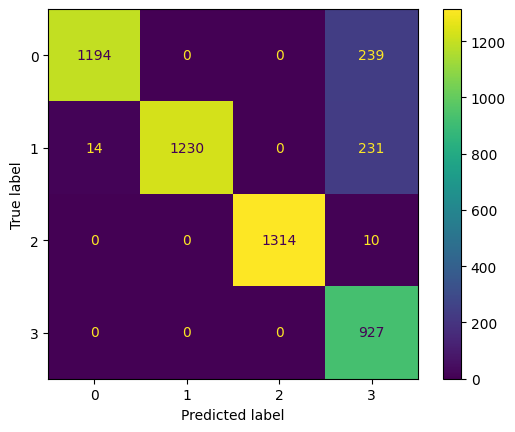

Epoch 3 done. Eval loss: 0.7912143019907816 Eval accuracy: 0.8998842835426331


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 61.76it/s]

Epoch: 4 (0/326) Training loss: 0.7928729017628829


31it [00:00, 75.44it/s]

Epoch: 4 (20/326) Training loss: 0.7873971164333549


55it [00:00, 78.28it/s]

Epoch: 4 (40/326) Training loss: 0.8991082366118318


71it [00:00, 78.52it/s]

Epoch: 4 (60/326) Training loss: 0.8150107513955864


97it [00:01, 79.89it/s]

Epoch: 4 (80/326) Training loss: 0.786805876164029


113it [00:01, 78.52it/s]

Epoch: 4 (100/326) Training loss: 0.8592520438758342


129it [00:01, 78.22it/s]

Epoch: 4 (120/326) Training loss: 0.7881815315878


153it [00:01, 78.57it/s]

Epoch: 4 (140/326) Training loss: 0.753908517215589


169it [00:02, 78.63it/s]

Epoch: 4 (160/326) Training loss: 0.7639171645827905


195it [00:02, 79.99it/s]

Epoch: 4 (180/326) Training loss: 0.7437146212607151


212it [00:02, 80.06it/s]

Epoch: 4 (200/326) Training loss: 0.7683166460931127


230it [00:02, 79.59it/s]

Epoch: 4 (220/326) Training loss: 0.7537418046790593


254it [00:03, 78.65it/s]

Epoch: 4 (240/326) Training loss: 0.7939514441459663


271it [00:03, 78.11it/s]

Epoch: 4 (260/326) Training loss: 0.7638182677398422


296it [00:03, 78.98it/s]

Epoch: 4 (280/326) Training loss: 0.7637897514016487


312it [00:03, 77.94it/s]

Epoch: 4 (300/326) Training loss: 0.7637917012508003


326it [00:04, 78.30it/s]


Epoch: 4 (320/326) Training loss: 0.7679047331642197
Epoch 4 done. Training loss: 0.7903702942552958 Training accuracy: 0.935630738735199


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 133.45it/s]


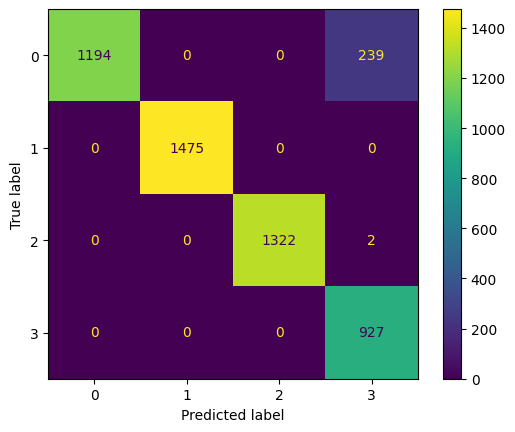

Epoch 4 done. Eval loss: 0.7749430337993495 Eval accuracy: 0.948688268661499


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 65.10it/s]

Epoch: 5 (0/326) Training loss: 0.7738652132199889


31it [00:00, 73.93it/s]

Epoch: 5 (20/326) Training loss: 0.7839011950392567


55it [00:00, 74.94it/s]

Epoch: 5 (40/326) Training loss: 0.9671239921168051


71it [00:00, 75.08it/s]

Epoch: 5 (60/326) Training loss: 0.7572467802260028


95it [00:01, 77.21it/s]

Epoch: 5 (80/326) Training loss: 0.8039527683922689


112it [00:01, 78.35it/s]

Epoch: 5 (100/326) Training loss: 0.7759934142383105


128it [00:01, 76.84it/s]

Epoch: 5 (120/326) Training loss: 0.7812688251354561


153it [00:02, 77.69it/s]

Epoch: 5 (140/326) Training loss: 0.8021384886958848


169it [00:02, 78.14it/s]

Epoch: 5 (160/326) Training loss: 0.8125197022716458


194it [00:02, 79.29it/s]

Epoch: 5 (180/326) Training loss: 0.7914900777185521


210it [00:02, 77.94it/s]

Epoch: 5 (200/326) Training loss: 0.7538677972267314


234it [00:03, 77.03it/s]

Epoch: 5 (220/326) Training loss: 0.7461762462647437


250it [00:03, 77.47it/s]

Epoch: 5 (240/326) Training loss: 0.755210790189871


276it [00:03, 79.67it/s]

Epoch: 5 (260/326) Training loss: 0.784250155023489


292it [00:03, 79.49it/s]

Epoch: 5 (280/326) Training loss: 0.7738185725023367


308it [00:04, 75.58it/s]

Epoch: 5 (300/326) Training loss: 0.773841920751144


326it [00:04, 76.72it/s]


Epoch: 5 (320/326) Training loss: 0.7838885997422296
Epoch 5 done. Training loss: 0.7815017310262103 Training accuracy: 0.9479486346244812


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 131.25it/s]


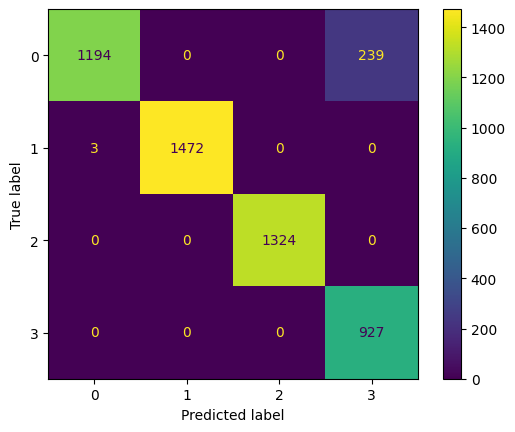

Epoch 5 done. Eval loss: 0.7743388198684762 Eval accuracy: 0.9484953880310059


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
6it [00:00, 59.58it/s]

Epoch: 6 (0/326) Training loss: 0.773861806970236


35it [00:00, 72.52it/s]

Epoch: 6 (20/326) Training loss: 0.7838741918549168


51it [00:00, 73.83it/s]

Epoch: 6 (40/326) Training loss: 0.7537266050348731


75it [00:01, 72.77it/s]

Epoch: 6 (60/326) Training loss: 0.794595502696066


91it [00:01, 75.34it/s]

Epoch: 6 (80/326) Training loss: 0.7749956275245969


116it [00:01, 76.77it/s]

Epoch: 6 (100/326) Training loss: 0.7840539312484488


132it [00:01, 76.16it/s]

Epoch: 6 (120/326) Training loss: 0.7838928881822933


156it [00:02, 76.86it/s]

Epoch: 6 (140/326) Training loss: 0.7637678163788713


172it [00:02, 76.78it/s]

Epoch: 6 (160/326) Training loss: 0.7537603741290038


196it [00:02, 77.70it/s]

Epoch: 6 (180/326) Training loss: 0.7939058577791627


212it [00:02, 76.67it/s]

Epoch: 6 (200/326) Training loss: 0.793914381013946


229it [00:03, 78.30it/s]

Epoch: 6 (220/326) Training loss: 0.7638008125094968


253it [00:03, 78.08it/s]

Epoch: 6 (240/326) Training loss: 0.7939015494941641


269it [00:03, 77.72it/s]

Epoch: 6 (260/326) Training loss: 0.7738284058302412


294it [00:03, 79.25it/s]

Epoch: 6 (280/326) Training loss: 0.7938911688490367


310it [00:04, 77.24it/s]

Epoch: 6 (300/326) Training loss: 0.7638329663380736


326it [00:04, 75.89it/s]


Epoch: 6 (320/326) Training loss: 0.7939047505605061
Epoch 6 done. Training loss: 0.7738848620254071 Training accuracy: 0.9516391754150391


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 133.49it/s]


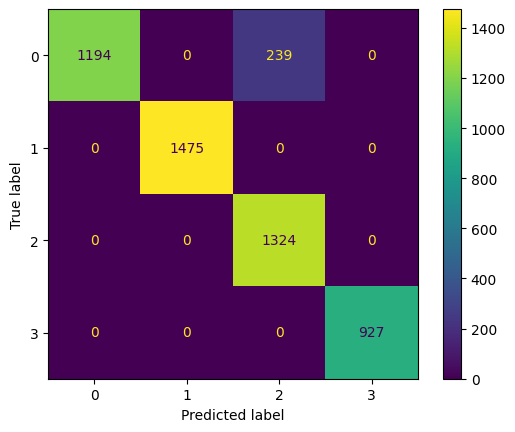

Epoch 6 done. Eval loss: 0.7736338104152517 Eval accuracy: 0.9490740895271301


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 69.67it/s]

Epoch: 7 (0/326) Training loss: 0.7738011298267211


30it [00:00, 74.74it/s]

Epoch: 7 (20/326) Training loss: 0.7938997528991619


54it [00:00, 76.17it/s]

Epoch: 7 (40/326) Training loss: 0.7637621327894621


70it [00:00, 75.52it/s]

Epoch: 7 (60/326) Training loss: 0.7637633560862387


95it [00:01, 77.62it/s]

Epoch: 7 (80/326) Training loss: 0.7938842082291944


111it [00:01, 77.51it/s]

Epoch: 7 (100/326) Training loss: 0.8039278714205635


135it [00:01, 77.57it/s]

Epoch: 7 (120/326) Training loss: 0.7637671662780376


151it [00:02, 73.26it/s]

Epoch: 7 (140/326) Training loss: 0.7841779079473593


176it [00:02, 76.91it/s]

Epoch: 7 (160/326) Training loss: 0.7838430740182315


192it [00:02, 77.21it/s]

Epoch: 7 (180/326) Training loss: 0.7637627363551978


216it [00:02, 73.03it/s]

Epoch: 7 (200/326) Training loss: 0.7738021765537906


232it [00:03, 74.60it/s]

Epoch: 7 (220/326) Training loss: 0.7738007259771514


256it [00:03, 75.20it/s]

Epoch: 7 (240/326) Training loss: 0.7637615080955545


272it [00:03, 76.54it/s]

Epoch: 7 (260/326) Training loss: 0.7838480652661044


289it [00:03, 77.16it/s]

Epoch: 7 (280/326) Training loss: 0.7436846201743034


315it [00:04, 78.48it/s]

Epoch: 7 (300/326) Training loss: 0.7637581026588524


326it [00:04, 75.90it/s]


Epoch: 7 (320/326) Training loss: 0.7838446469660625
Epoch 7 done. Training loss: 0.7734143227059723 Training accuracy: 0.9518788456916809


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 134.60it/s]


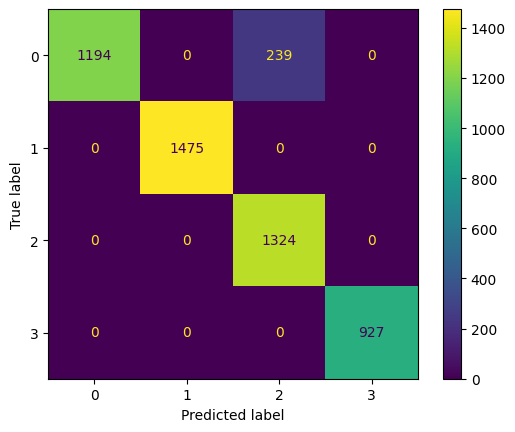

Epoch 7 done. Eval loss: 0.7736465801187187 Eval accuracy: 0.9490740895271301


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 68.06it/s]

Epoch: 8 (0/326) Training loss: 0.7938836429025382


31it [00:00, 75.23it/s]

Epoch: 8 (20/326) Training loss: 0.7737999459303917


55it [00:00, 75.16it/s]

Epoch: 8 (40/326) Training loss: 0.7637588780652003


71it [00:00, 76.77it/s]

Epoch: 8 (60/326) Training loss: 0.7436752867478262


95it [00:01, 77.23it/s]

Epoch: 8 (80/326) Training loss: 0.7638499789228115


111it [00:01, 76.97it/s]

Epoch: 8 (100/326) Training loss: 0.7738054715373965


136it [00:01, 78.96it/s]

Epoch: 8 (120/326) Training loss: 0.7859780386673451


152it [00:01, 77.52it/s]

Epoch: 8 (140/326) Training loss: 0.7537149000019052


176it [00:02, 76.53it/s]

Epoch: 8 (160/326) Training loss: 0.7537234982751514


192it [00:02, 76.97it/s]

Epoch: 8 (180/326) Training loss: 0.7637586321521594


217it [00:02, 78.38it/s]

Epoch: 8 (200/326) Training loss: 0.753719843755879


233it [00:03, 76.14it/s]

Epoch: 8 (220/326) Training loss: 0.7638595936632137


249it [00:03, 75.82it/s]

Epoch: 8 (240/326) Training loss: 0.7838457481220099


273it [00:03, 74.46it/s]

Epoch: 8 (260/326) Training loss: 0.8039341850757484


289it [00:03, 75.52it/s]

Epoch: 8 (280/326) Training loss: 0.8139703336694126


314it [00:04, 75.23it/s]

Epoch: 8 (300/326) Training loss: 0.7637575419745213


326it [00:04, 76.39it/s]


Epoch: 8 (320/326) Training loss: 0.7637546533536067
Epoch 8 done. Training loss: 0.7734123073307381 Training accuracy: 0.9517830014228821


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 129.59it/s]


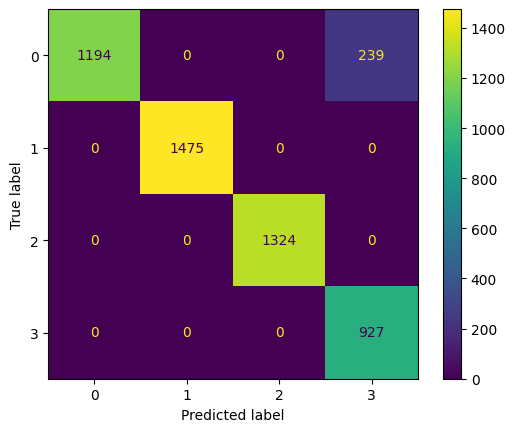

Epoch 8 done. Eval loss: 0.7736288055786252 Eval accuracy: 0.9490740895271301


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
7it [00:00, 62.42it/s]

Epoch: 9 (0/326) Training loss: 0.7537157781186815


31it [00:00, 71.31it/s]

Epoch: 9 (20/326) Training loss: 0.8039248687876824


55it [00:00, 73.26it/s]

Epoch: 9 (40/326) Training loss: 0.7637568842176339


71it [00:00, 74.62it/s]

Epoch: 9 (60/326) Training loss: 0.7737995714112974


95it [00:01, 76.91it/s]

Epoch: 9 (80/326) Training loss: 0.753715855152226


111it [00:01, 75.21it/s]

Epoch: 9 (100/326) Training loss: 0.7737988198279411


135it [00:01, 73.95it/s]

Epoch: 9 (120/326) Training loss: 0.7637569180213966


151it [00:02, 75.01it/s]

Epoch: 9 (140/326) Training loss: 0.7738010792705424


176it [00:02, 77.17it/s]

Epoch: 9 (160/326) Training loss: 0.7738003886813402


192it [00:02, 76.40it/s]

Epoch: 9 (180/326) Training loss: 0.7938926821209664


208it [00:02, 73.94it/s]

Epoch: 9 (200/326) Training loss: 0.7637700936053298


233it [00:03, 76.72it/s]

Epoch: 9 (220/326) Training loss: 0.8039268660653194


249it [00:03, 73.97it/s]

Epoch: 9 (240/326) Training loss: 0.7637607797695989


274it [00:03, 77.54it/s]

Epoch: 9 (260/326) Training loss: 0.7537134487715538


290it [00:03, 78.01it/s]

Epoch: 9 (280/326) Training loss: 0.7538982302356559


316it [00:04, 79.32it/s]

Epoch: 9 (300/326) Training loss: 0.7839004246566691


326it [00:04, 75.46it/s]


Epoch: 9 (320/326) Training loss: 0.7537303897223491
Epoch 9 done. Training loss: 0.7738078324832746 Training accuracy: 0.9514954090118408


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 133.13it/s]


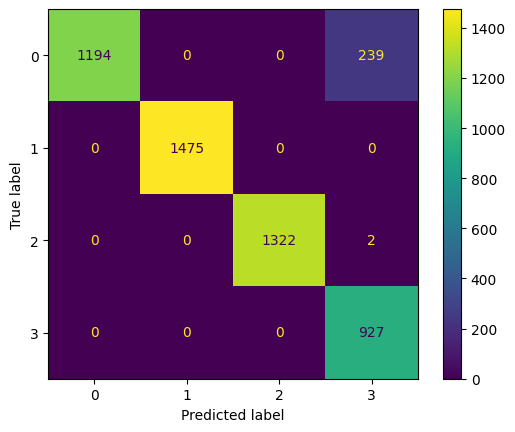

Epoch 9 done. Eval loss: 0.7739653249007592 Eval accuracy: 0.948688268661499


In [377]:
import torch.nn.functional as f
# LSTM 1
input_dim = 9
hidden_dim = 6 
layer_dim = 1 
output_dim = 4 
dropout_prob = 0
bi = False
fc_dim = 480
rnn = GRUModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bi)
optimizer = torch.optim.Adam(rnn.parameters(),lr=1e-2,weight_decay=0)
rnn.double()

criterion = nn.CrossEntropyLoss()

EPOCHS = 10

loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(rnn, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(rnn, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)

0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
9it [00:00, 43.35it/s]

Epoch: 0 (0/326) Training loss: 1.4211344132989883


26it [00:00, 48.47it/s]

Epoch: 0 (20/326) Training loss: 1.035161968586448


49it [00:01, 49.86it/s]

Epoch: 0 (40/326) Training loss: 0.920096743395669


70it [00:01, 50.29it/s]

Epoch: 0 (60/326) Training loss: 0.8763774663139876


86it [00:01, 48.09it/s]

Epoch: 0 (80/326) Training loss: 0.8588958297164353


109it [00:02, 49.99it/s]

Epoch: 0 (100/326) Training loss: 0.8404006166566453


127it [00:02, 50.67it/s]

Epoch: 0 (120/326) Training loss: 0.8832858282013301


151it [00:03, 51.02it/s]

Epoch: 0 (140/326) Training loss: 0.8221604185771855


169it [00:03, 50.36it/s]

Epoch: 0 (160/326) Training loss: 0.8844386748810749


187it [00:03, 50.47it/s]

Epoch: 0 (180/326) Training loss: 0.8253060835187251


211it [00:04, 50.99it/s]

Epoch: 0 (200/326) Training loss: 0.810629280205668


229it [00:04, 49.40it/s]

Epoch: 0 (220/326) Training loss: 0.8497807828405445


247it [00:04, 50.50it/s]

Epoch: 0 (240/326) Training loss: 0.8013968907597424


271it [00:05, 50.67it/s]

Epoch: 0 (260/326) Training loss: 0.7861028757274058


289it [00:05, 46.45it/s]

Epoch: 0 (280/326) Training loss: 0.788516362100147


311it [00:06, 49.22it/s]

Epoch: 0 (300/326) Training loss: 0.7911667663939284


326it [00:06, 49.70it/s]


Epoch: 0 (320/326) Training loss: 0.7739108720027753
Epoch 0 done. Training loss: 0.8605421112129724 Training accuracy: 0.8483033180236816


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 100.88it/s]


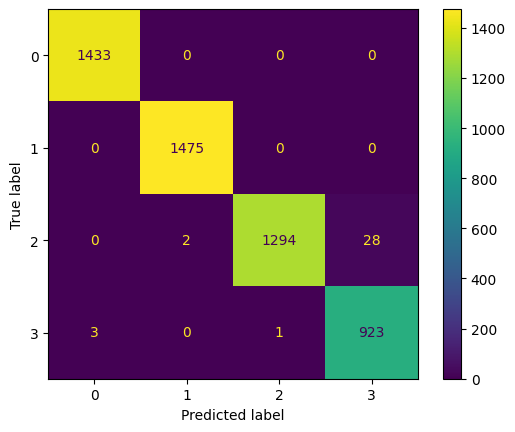

Epoch 0 done. Eval loss: 0.7706144612033816 Eval accuracy: 0.9886188507080078


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
5it [00:00, 44.13it/s]

Epoch: 1 (0/326) Training loss: 0.7703231669178874


27it [00:00, 48.74it/s]

Epoch: 1 (20/326) Training loss: 0.7616902055319521


51it [00:01, 50.69it/s]

Epoch: 1 (40/326) Training loss: 0.7560946174756464


69it [00:01, 49.86it/s]

Epoch: 1 (60/326) Training loss: 0.7534495622125765


87it [00:01, 50.67it/s]

Epoch: 1 (80/326) Training loss: 0.7555940373023085


111it [00:02, 51.43it/s]

Epoch: 1 (100/326) Training loss: 0.7540635962534474


129it [00:02, 51.22it/s]

Epoch: 1 (120/326) Training loss: 0.7497817090521934


147it [00:02, 50.98it/s]

Epoch: 1 (140/326) Training loss: 0.748299988044561


171it [00:03, 51.07it/s]

Epoch: 1 (160/326) Training loss: 0.7469832697571865


189it [00:03, 50.83it/s]

Epoch: 1 (180/326) Training loss: 0.7483508041750822


207it [00:04, 50.18it/s]

Epoch: 1 (200/326) Training loss: 0.7461487198528253


231it [00:04, 50.69it/s]

Epoch: 1 (220/326) Training loss: 0.7467283760226424


249it [00:04, 50.69it/s]

Epoch: 1 (240/326) Training loss: 0.7483965231655674


267it [00:05, 50.58it/s]

Epoch: 1 (260/326) Training loss: 0.7494657781743259


291it [00:05, 51.14it/s]

Epoch: 1 (280/326) Training loss: 0.7459596074334123


309it [00:06, 50.64it/s]

Epoch: 1 (300/326) Training loss: 0.7465778826625307


326it [00:06, 50.58it/s]

Epoch: 1 (320/326) Training loss: 0.7456970324572368
Epoch 1 done. Training loss: 0.7529482340171135 Training accuracy: 0.996788740158081



0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 100.22it/s]


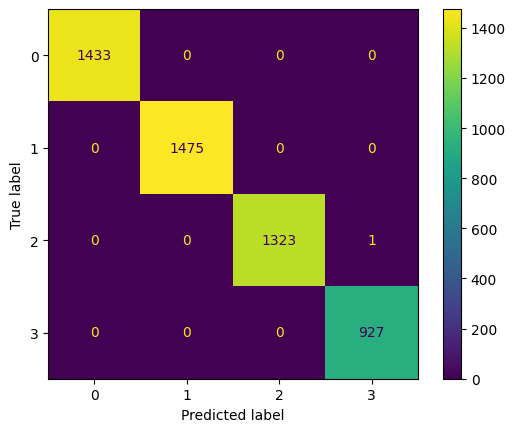

Epoch 1 done. Eval loss: 0.7464052806393753 Eval accuracy: 0.9949845671653748


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 34.94it/s]

Epoch: 2 (0/326) Training loss: 0.7490283990562817


26it [00:00, 48.68it/s]

Epoch: 2 (20/326) Training loss: 0.7473496302372343


49it [00:01, 49.74it/s]

Epoch: 2 (40/326) Training loss: 0.7464410196914423


67it [00:01, 50.41it/s]

Epoch: 2 (60/326) Training loss: 0.7454129158744336


91it [00:01, 51.10it/s]

Epoch: 2 (80/326) Training loss: 0.7471382093451929


109it [00:02, 50.46it/s]

Epoch: 2 (100/326) Training loss: 0.7447550092761983


127it [00:02, 50.37it/s]

Epoch: 2 (120/326) Training loss: 0.7457703413025754


151it [00:03, 51.24it/s]

Epoch: 2 (140/326) Training loss: 0.7446733272194095


169it [00:03, 51.09it/s]

Epoch: 2 (160/326) Training loss: 0.7482879292276701


187it [00:03, 50.43it/s]

Epoch: 2 (180/326) Training loss: 0.7451821240385649


211it [00:04, 50.76it/s]

Epoch: 2 (200/326) Training loss: 0.7446880911035856


229it [00:04, 51.20it/s]

Epoch: 2 (220/326) Training loss: 0.748963704372649


247it [00:04, 50.44it/s]

Epoch: 2 (240/326) Training loss: 0.7445570680448157


271it [00:05, 50.14it/s]

Epoch: 2 (260/326) Training loss: 0.7443997212169567


287it [00:05, 48.68it/s]

Epoch: 2 (280/326) Training loss: 0.7444020129239188


308it [00:06, 49.21it/s]

Epoch: 2 (300/326) Training loss: 0.7446352426311234


326it [00:06, 49.32it/s]


Epoch: 2 (320/326) Training loss: 0.7471278997529676
Epoch 2 done. Training loss: 0.7457654163800053 Training accuracy: 0.9976035356521606


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 99.95it/s] 


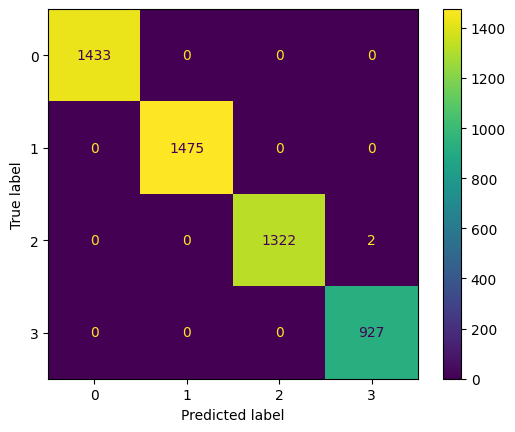

Epoch 2 done. Eval loss: 0.7449519402784046 Eval accuracy: 0.9947916865348816


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
5it [00:00, 44.44it/s]

Epoch: 3 (0/326) Training loss: 0.7442258028876823


27it [00:00, 48.94it/s]

Epoch: 3 (20/326) Training loss: 0.7443026888717246


51it [00:01, 50.82it/s]

Epoch: 3 (40/326) Training loss: 0.7445072301005728


69it [00:01, 50.76it/s]

Epoch: 3 (60/326) Training loss: 0.7444448122636578


86it [00:01, 48.49it/s]

Epoch: 3 (80/326) Training loss: 0.7444844868242303


108it [00:02, 49.67it/s]

Epoch: 3 (100/326) Training loss: 0.7444133411313836


128it [00:02, 44.30it/s]

Epoch: 3 (120/326) Training loss: 0.7449749738663469


150it [00:03, 48.27it/s]

Epoch: 3 (140/326) Training loss: 0.7443545437229357


166it [00:03, 48.27it/s]

Epoch: 3 (160/326) Training loss: 0.7442418250508166


190it [00:03, 50.40it/s]

Epoch: 3 (180/326) Training loss: 0.745642016242335


208it [00:04, 51.20it/s]

Epoch: 3 (200/326) Training loss: 0.744127656104448


226it [00:04, 51.70it/s]

Epoch: 3 (220/326) Training loss: 0.744176225743186


250it [00:05, 51.18it/s]

Epoch: 3 (240/326) Training loss: 0.7443928879006232


268it [00:05, 51.36it/s]

Epoch: 3 (260/326) Training loss: 0.7444571190164851


286it [00:05, 50.95it/s]

Epoch: 3 (280/326) Training loss: 0.744546079101395


308it [00:06, 45.31it/s]

Epoch: 3 (300/326) Training loss: 0.7448358218061011


326it [00:06, 48.99it/s]


Epoch: 3 (320/326) Training loss: 0.7443242458742588
Epoch 3 done. Training loss: 0.7445778686394011 Training accuracy: 0.9976993799209595


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 101.23it/s]


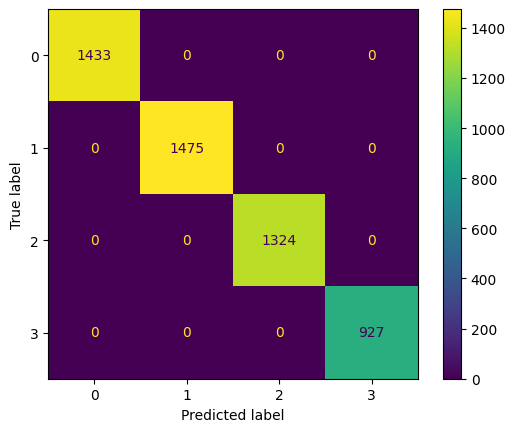

Epoch 3 done. Eval loss: 0.7445873324362544 Eval accuracy: 0.9951774477958679


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 37.46it/s]

Epoch: 4 (0/326) Training loss: 0.744178644529321


30it [00:00, 48.21it/s]

Epoch: 4 (20/326) Training loss: 0.751756684170874


47it [00:00, 49.78it/s]

Epoch: 4 (40/326) Training loss: 0.7439863945839735


71it [00:01, 51.29it/s]

Epoch: 4 (60/326) Training loss: 0.7441596111564739


89it [00:01, 50.89it/s]

Epoch: 4 (80/326) Training loss: 0.7442680917033481


107it [00:02, 50.19it/s]

Epoch: 4 (100/326) Training loss: 0.743981692409375


131it [00:02, 50.81it/s]

Epoch: 4 (120/326) Training loss: 0.7440245001689453


149it [00:02, 50.96it/s]

Epoch: 4 (140/326) Training loss: 0.7439314809970862


167it [00:03, 50.82it/s]

Epoch: 4 (160/326) Training loss: 0.7444325270979266


191it [00:03, 51.42it/s]

Epoch: 4 (180/326) Training loss: 0.7440299667284491


209it [00:04, 51.10it/s]

Epoch: 4 (200/326) Training loss: 0.7443749096047021


227it [00:04, 50.73it/s]

Epoch: 4 (220/326) Training loss: 0.7442103726476552


251it [00:04, 50.95it/s]

Epoch: 4 (240/326) Training loss: 0.7439875783872247


269it [00:05, 51.03it/s]

Epoch: 4 (260/326) Training loss: 0.743893854603244


287it [00:05, 51.15it/s]

Epoch: 4 (280/326) Training loss: 0.7439309665031109


309it [00:06, 49.11it/s]

Epoch: 4 (300/326) Training loss: 0.7440687357583443


326it [00:06, 50.15it/s]

Epoch: 4 (320/326) Training loss: 0.744024207108613
Epoch 4 done. Training loss: 0.7443969438755388 Training accuracy: 0.9977473020553589



0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 103.70it/s]


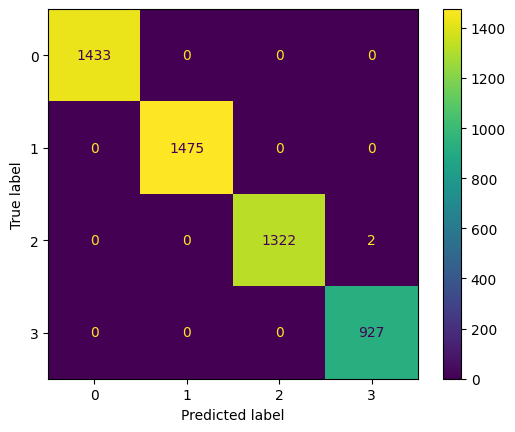

Epoch 4 done. Eval loss: 0.7442648853730147 Eval accuracy: 0.9947916865348816


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 38.68it/s]

Epoch: 5 (0/326) Training loss: 0.7440110865794151


30it [00:00, 46.98it/s]

Epoch: 5 (20/326) Training loss: 0.7442324877616001


47it [00:00, 49.15it/s]

Epoch: 5 (40/326) Training loss: 0.7438485564920915


70it [00:01, 50.11it/s]

Epoch: 5 (60/326) Training loss: 0.7438838247613276


88it [00:01, 50.92it/s]

Epoch: 5 (80/326) Training loss: 0.7438798033259759


106it [00:02, 50.87it/s]

Epoch: 5 (100/326) Training loss: 0.7439315234364909


130it [00:02, 50.20it/s]

Epoch: 5 (120/326) Training loss: 0.7438450812151435


148it [00:03, 50.53it/s]

Epoch: 5 (140/326) Training loss: 0.7439439969944313


166it [00:03, 50.20it/s]

Epoch: 5 (160/326) Training loss: 0.7457134528422256


190it [00:03, 51.54it/s]

Epoch: 5 (180/326) Training loss: 0.7441956749875196


208it [00:04, 51.47it/s]

Epoch: 5 (200/326) Training loss: 0.7439675791826232


226it [00:04, 51.36it/s]

Epoch: 5 (220/326) Training loss: 0.7438909047151341


250it [00:05, 51.23it/s]

Epoch: 5 (240/326) Training loss: 0.7438585544818423


268it [00:05, 51.73it/s]

Epoch: 5 (260/326) Training loss: 0.743910987102053


286it [00:05, 51.58it/s]

Epoch: 5 (280/326) Training loss: 0.7439302906567578


304it [00:06, 47.36it/s]

Epoch: 5 (300/326) Training loss: 0.7438923247528652


326it [00:06, 50.17it/s]


Epoch: 5 (320/326) Training loss: 0.7438850515447228
Epoch 5 done. Training loss: 0.7440984036154172 Training accuracy: 0.9977952241897583


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 102.80it/s]


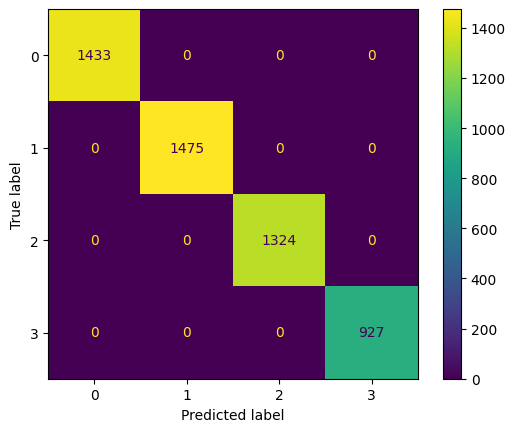

Epoch 5 done. Eval loss: 0.7439918139280253 Eval accuracy: 0.9951774477958679


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
5it [00:00, 44.21it/s]

Epoch: 6 (0/326) Training loss: 0.7438239206113257


26it [00:00, 47.01it/s]

Epoch: 6 (20/326) Training loss: 0.7439942917979028


48it [00:01, 49.75it/s]

Epoch: 6 (40/326) Training loss: 0.7438259815076416


71it [00:01, 50.46it/s]

Epoch: 6 (60/326) Training loss: 0.7438388457164691


89it [00:01, 50.64it/s]

Epoch: 6 (80/326) Training loss: 0.7438107221624167


106it [00:02, 49.49it/s]

Epoch: 6 (100/326) Training loss: 0.7438498648699826


126it [00:02, 49.17it/s]

Epoch: 6 (120/326) Training loss: 0.7440397032519979


149it [00:03, 50.38it/s]

Epoch: 6 (140/326) Training loss: 0.7438343440598068


167it [00:03, 50.88it/s]

Epoch: 6 (160/326) Training loss: 0.7437905192860307


191it [00:03, 51.21it/s]

Epoch: 6 (180/326) Training loss: 0.7440735948358634


209it [00:04, 51.01it/s]

Epoch: 6 (200/326) Training loss: 0.7438440950898637


227it [00:04, 51.14it/s]

Epoch: 6 (220/326) Training loss: 0.7444503067835185


251it [00:05, 51.24it/s]

Epoch: 6 (240/326) Training loss: 0.7440148744045569


269it [00:05, 51.51it/s]

Epoch: 6 (260/326) Training loss: 0.7438962055365804


287it [00:05, 51.53it/s]

Epoch: 6 (280/326) Training loss: 0.743781695093978


311it [00:06, 51.74it/s]

Epoch: 6 (300/326) Training loss: 0.743865051722744


326it [00:06, 50.30it/s]


Epoch: 6 (320/326) Training loss: 0.7438280581573047
Epoch 6 done. Training loss: 0.7440000326612258 Training accuracy: 0.9977473020553589


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 104.52it/s]


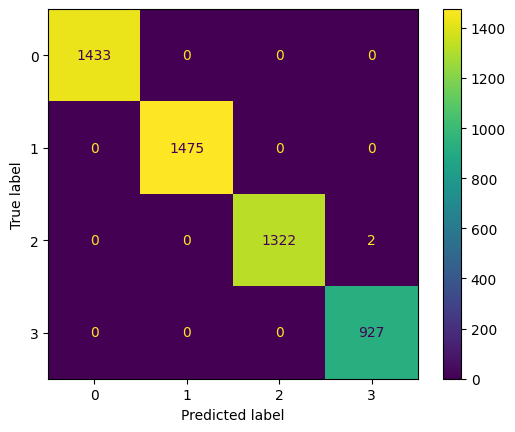

Epoch 6 done. Eval loss: 0.7441277004406057 Eval accuracy: 0.9947916865348816


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
5it [00:00, 46.87it/s]

Epoch: 7 (0/326) Training loss: 0.7440180608633


27it [00:00, 50.37it/s]

Epoch: 7 (20/326) Training loss: 0.7437737126370282


51it [00:01, 50.67it/s]

Epoch: 7 (40/326) Training loss: 0.7438107906500521


69it [00:01, 49.85it/s]

Epoch: 7 (60/326) Training loss: 0.7438916878239825


86it [00:01, 47.61it/s]

Epoch: 7 (80/326) Training loss: 0.7437919547424008


109it [00:02, 49.59it/s]

Epoch: 7 (100/326) Training loss: 0.7438396091900509


126it [00:02, 49.71it/s]

Epoch: 7 (120/326) Training loss: 0.7439653365384592


148it [00:03, 49.68it/s]

Epoch: 7 (140/326) Training loss: 0.7437784806732115


166it [00:03, 50.80it/s]

Epoch: 7 (160/326) Training loss: 0.7437819664039788


190it [00:03, 50.87it/s]

Epoch: 7 (180/326) Training loss: 0.7438983437890139


208it [00:04, 51.48it/s]

Epoch: 7 (200/326) Training loss: 0.7438327833435803


226it [00:04, 51.43it/s]

Epoch: 7 (220/326) Training loss: 0.7438528880630391


250it [00:04, 51.30it/s]

Epoch: 7 (240/326) Training loss: 0.7438214727491679


268it [00:05, 51.55it/s]

Epoch: 7 (260/326) Training loss: 0.7438730389226762


286it [00:05, 51.67it/s]

Epoch: 7 (280/326) Training loss: 0.7438899870506749


310it [00:06, 51.38it/s]

Epoch: 7 (300/326) Training loss: 0.743771956674091


326it [00:06, 50.46it/s]


Epoch: 7 (320/326) Training loss: 0.7437881366411614
Epoch 7 done. Training loss: 0.744011491824424 Training accuracy: 0.9976993799209595


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 103.13it/s]


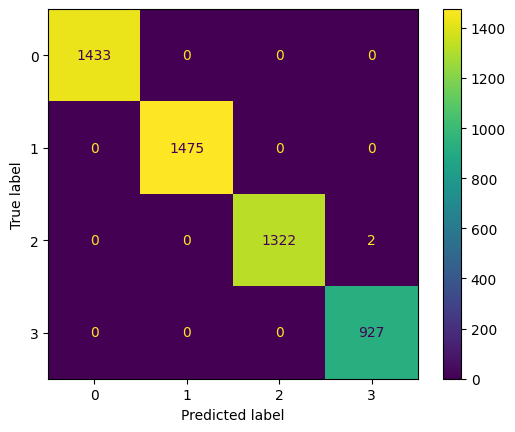

Epoch 7 done. Eval loss: 0.7441003978260339 Eval accuracy: 0.9947916865348816


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
4it [00:00, 38.78it/s]

Epoch: 8 (0/326) Training loss: 0.7438050864205006


31it [00:00, 49.83it/s]

Epoch: 8 (20/326) Training loss: 0.7438043991896965


49it [00:00, 50.79it/s]

Epoch: 8 (40/326) Training loss: 0.7438220781669334


66it [00:01, 49.99it/s]

Epoch: 8 (60/326) Training loss: 0.7437617736123249


86it [00:01, 46.02it/s]

Epoch: 8 (80/326) Training loss: 0.7437778078442298


109it [00:02, 49.28it/s]

Epoch: 8 (100/326) Training loss: 0.7437155942956526


126it [00:02, 49.90it/s]

Epoch: 8 (120/326) Training loss: 0.7438956812686498


150it [00:03, 50.93it/s]

Epoch: 8 (140/326) Training loss: 0.7438033976201315


168it [00:03, 51.31it/s]

Epoch: 8 (160/326) Training loss: 0.7437817864891176


186it [00:03, 51.05it/s]

Epoch: 8 (180/326) Training loss: 0.7438374369727323


210it [00:04, 51.06it/s]

Epoch: 8 (200/326) Training loss: 0.7437497354369157


228it [00:04, 50.94it/s]

Epoch: 8 (220/326) Training loss: 0.7444615157798644


246it [00:04, 51.14it/s]

Epoch: 8 (240/326) Training loss: 0.743745829445347


270it [00:05, 51.17it/s]

Epoch: 8 (260/326) Training loss: 0.7437257498014


288it [00:05, 51.14it/s]

Epoch: 8 (280/326) Training loss: 0.7438689382441921


306it [00:06, 50.31it/s]

Epoch: 8 (300/326) Training loss: 0.7437638359509259


326it [00:06, 50.10it/s]


Epoch: 8 (320/326) Training loss: 0.7437643662658564
Epoch 8 done. Training loss: 0.7439064707523323 Training accuracy: 0.9977952241897583


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 103.67it/s]


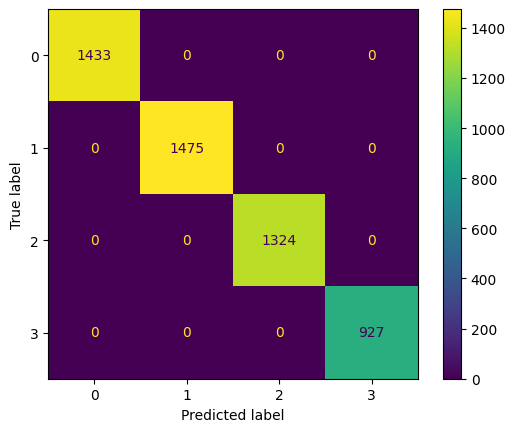

Epoch 8 done. Eval loss: 0.7439039559987374 Eval accuracy: 0.9951774477958679


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/3949362538.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
5it [00:00, 44.87it/s]

Epoch: 9 (0/326) Training loss: 0.7437604641687784


27it [00:00, 49.07it/s]

Epoch: 9 (20/326) Training loss: 0.7439407149881766


48it [00:00, 49.51it/s]

Epoch: 9 (40/326) Training loss: 0.7438718623720968


71it [00:01, 50.63it/s]

Epoch: 9 (60/326) Training loss: 0.7438648886861214


89it [00:01, 50.49it/s]

Epoch: 9 (80/326) Training loss: 0.7437509095071227


107it [00:02, 50.11it/s]

Epoch: 9 (100/326) Training loss: 0.7439799955695615


129it [00:02, 47.81it/s]

Epoch: 9 (120/326) Training loss: 0.7437868644821851


151it [00:03, 49.58it/s]

Epoch: 9 (140/326) Training loss: 0.7442251027632247


169it [00:03, 50.45it/s]

Epoch: 9 (160/326) Training loss: 0.7438097659975449


187it [00:03, 51.26it/s]

Epoch: 9 (180/326) Training loss: 0.7437782065586459


211it [00:04, 50.77it/s]

Epoch: 9 (200/326) Training loss: 0.7437884554447948


229it [00:04, 50.30it/s]

Epoch: 9 (220/326) Training loss: 0.743762348418646


247it [00:04, 50.63it/s]

Epoch: 9 (240/326) Training loss: 0.7438811699644665


271it [00:05, 50.76it/s]

Epoch: 9 (260/326) Training loss: 0.7439500834719852


289it [00:05, 50.11it/s]

Epoch: 9 (280/326) Training loss: 0.7437641115660417


311it [00:06, 49.99it/s]

Epoch: 9 (300/326) Training loss: 0.7454976008297242


326it [00:06, 49.99it/s]


Epoch: 9 (320/326) Training loss: 0.743944767343667
Epoch 9 done. Training loss: 0.7441029063636919 Training accuracy: 0.9976993799209595


0it [00:00, ?it/s]/var/folders/rh/zt1z2lr507g2bgh_6rkqmps40000gn/T/ipykernel_14134/493377646.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets.flatten(), dtype=torch.int64)
81it [00:00, 102.44it/s]


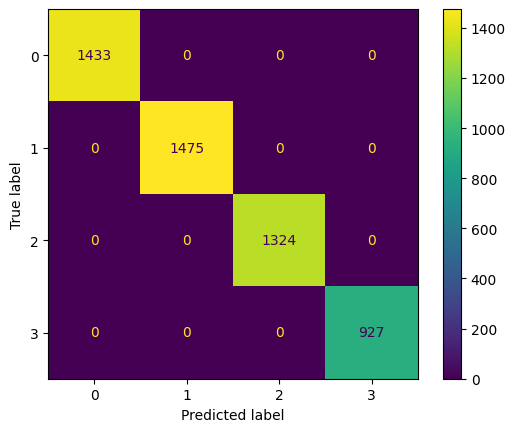

Epoch 9 done. Eval loss: 0.7437896174733404 Eval accuracy: 0.9951774477958679


In [378]:
# GRU 1
input_dim = 9
hidden_dim = 6 
layer_dim = 1 
output_dim = 4 
dropout_prob = 0
bi = True
fc_dim = 960
rnn = GRUModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bi)
optimizer = torch.optim.Adam(rnn.parameters(),lr=1e-3,weight_decay=0)
rnn.double()

criterion = nn.CrossEntropyLoss()

EPOCHS = 10

loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(rnn, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(rnn, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)